For this problen we use Image Segmentation An image is a collection or set of different pixels. We group together the pixels that have similar attributes using image segmentation.. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level.

## for this problem we are going to use Semantic Segmentation U-Net model

https://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html

In [3]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from zipfile import ZipFile 
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [4]:
train_zip = "/content/drive/MyDrive/DUTS-TR-Image.zip"
with ZipFile(train_zip, 'r') as zip_: 
    zip_.extractall('content')

In [5]:
train_mask_zip = "/content/drive/MyDrive/DUTS-TR-Mask.zip"
with ZipFile(train_mask_zip, 'r') as zip_: 
    zip_.extractall('content')

In [6]:
print("Image:  ", len(os.listdir("/content/content/DUTS-TR-Image")))
print("Masks:", len(os.listdir("/content/content/DUTS-TR-Mask")))

Image:   10553
Masks: 10553


In [7]:
from IPython.core.display import Image
image = []
paths = []
for dirname, _, filenames in os.walk('/content/content/DUTS-TR-Image'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        paths.append(path)
        
        image_id = filename.split(".")[0]
        image.append(image_id)

d = {"id": image, "image_path": paths}
df = pd.DataFrame(data = d)
df = df.set_index('id')
df.head()

image_path
id                                                                          
ILSVRC2013_test_00008612   /content/content/DUTS-TR-Image/ILSVRC2013_test...
ILSVRC2014_train_00019927  /content/content/DUTS-TR-Image/ILSVRC2014_trai...
n07714571_1565             /content/content/DUTS-TR-Image/n07714571_1565.jpg
sun_acswpgpfdacoxzay       /content/content/DUTS-TR-Image/sun_acswpgpfdac...
n02701002_4128             /content/content/DUTS-TR-Image/n02701002_4128.jpg

In [8]:
from IPython.core.display import Image
image = []
mask_path = []
for dirname, _, filenames in os.walk('/content/content/DUTS-TR-Mask'):
    for filename in filenames:
        path = os.path.join(dirname, filename)    
        mask_path.append(path)
        
        image_id = filename.split(".")[0]
        image_id = image_id.split("-Mask")[0]
        image.append(image_id)

d = {"id": image, "mask_path": mask_path}
mask_df = pd.DataFrame(data = d)
mask_df = mask_df.set_index('id')
mask_df.head()

mask_path
id                                                                         
n03775546_8657             /content/content/DUTS-TR-Mask/n03775546_8657.png
ILSVRC2012_test_00020037  /content/content/DUTS-TR-Mask/ILSVRC2012_test_...
ILSVRC2013_test_00007910  /content/content/DUTS-TR-Mask/ILSVRC2013_test_...
n07714571_17316           /content/content/DUTS-TR-Mask/n07714571_17316.png
n03710721_2131             /content/content/DUTS-TR-Mask/n03710721_2131.png

In [9]:
df["mask_path"] = mask_df["mask_path"]
df.head()

image_path  \
id                                                                             
ILSVRC2013_test_00008612   /content/content/DUTS-TR-Image/ILSVRC2013_test...   
ILSVRC2014_train_00019927  /content/content/DUTS-TR-Image/ILSVRC2014_trai...   
n07714571_1565             /content/content/DUTS-TR-Image/n07714571_1565.jpg   
sun_acswpgpfdacoxzay       /content/content/DUTS-TR-Image/sun_acswpgpfdac...   
n02701002_4128             /content/content/DUTS-TR-Image/n02701002_4128.jpg   

                                                                   mask_path  
id                                                                            
ILSVRC2013_test_00008612   /content/content/DUTS-TR-Mask/ILSVRC2013_test_...  
ILSVRC2014_train_00019927  /content/content/DUTS-TR-Mask/ILSVRC2014_train...  
n07714571_1565              /content/content/DUTS-TR-Mask/n07714571_1565.png  
sun_acswpgpfdacoxzay       /content/content/DUTS-TR-Mask/sun_acswpgpfdaco...  
n02701002_4128              /content/content/DUTS-TR-Mask/n02701002_4128.png

Now we usenormalize the image pixel in between 0 and 1.

In [10]:
img_size = [256,256]

def data_augmentation(img, mask_img):

    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask_img = tf.image.flip_left_right(mask_img)

    return img, mask_img

def preprocessing(image_path, mask_path):
    img = tf.io.read_file(image_path) 
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    
    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]    
    mask_img = tf.math.sign(mask_img)
    
    
    return img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["image_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["image_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        ds = ds.map(data_augmentation, tf.data.AUTOTUNE)

    return ds

In [11]:
df.head()

image_path  \
id                                                                             
ILSVRC2013_test_00008612   /content/content/DUTS-TR-Image/ILSVRC2013_test...   
ILSVRC2014_train_00019927  /content/content/DUTS-TR-Image/ILSVRC2014_trai...   
n07714571_1565             /content/content/DUTS-TR-Image/n07714571_1565.jpg   
sun_acswpgpfdacoxzay       /content/content/DUTS-TR-Image/sun_acswpgpfdac...   
n02701002_4128             /content/content/DUTS-TR-Image/n02701002_4128.jpg   

                                                                   mask_path  
id                                                                            
ILSVRC2013_test_00008612   /content/content/DUTS-TR-Mask/ILSVRC2013_test_...  
ILSVRC2014_train_00019927  /content/content/DUTS-TR-Mask/ILSVRC2014_train...  
n07714571_1565              /content/content/DUTS-TR-Mask/n07714571_1565.png  
sun_acswpgpfdacoxzay       /content/content/DUTS-TR-Mask/sun_acswpgpfdaco...  
n02701002_4128              /content/content/DUTS-TR-Mask/n02701002_4128.png

In [12]:
#Spliting dataset into train and test
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)

In [18]:
print(train_df.shape)
print(valid_df.shape)

(7914, 2)
(2639, 2)


In [19]:
TRAIN_LENGTH = len(train_df)
BATCH_SIZE = 16
BUFFER_SIZE = 1000

In [20]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)

In [21]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

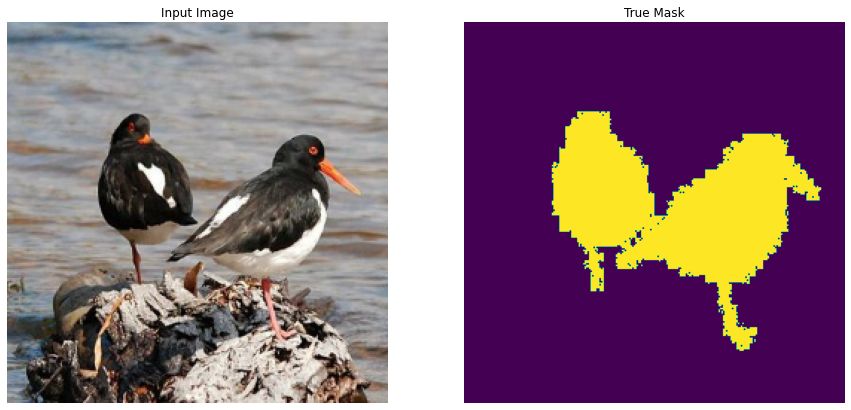

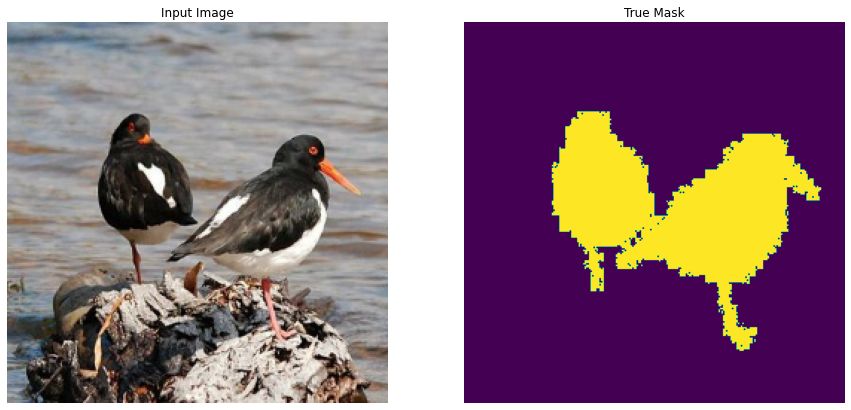

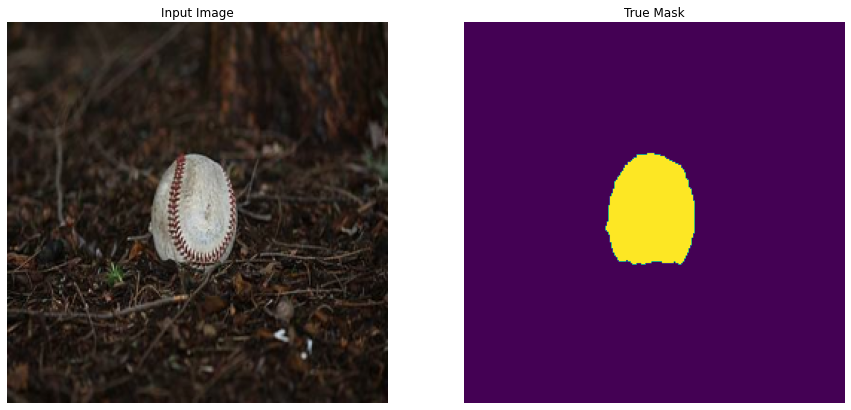

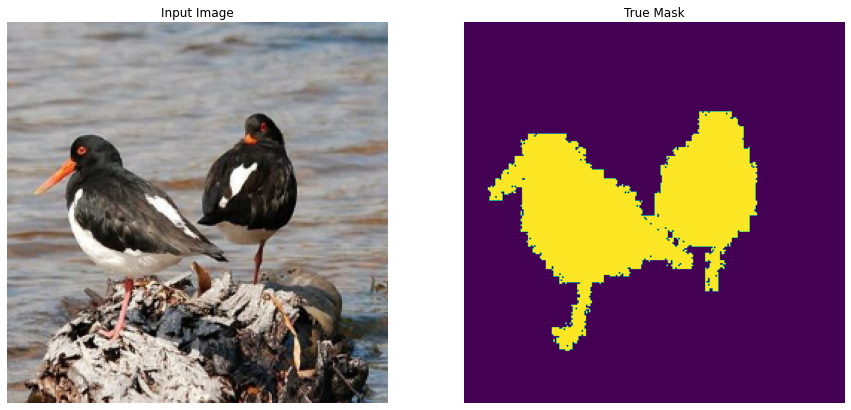

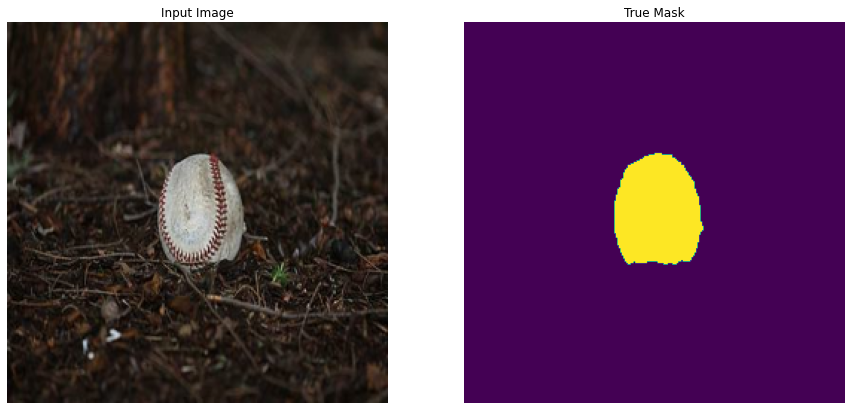

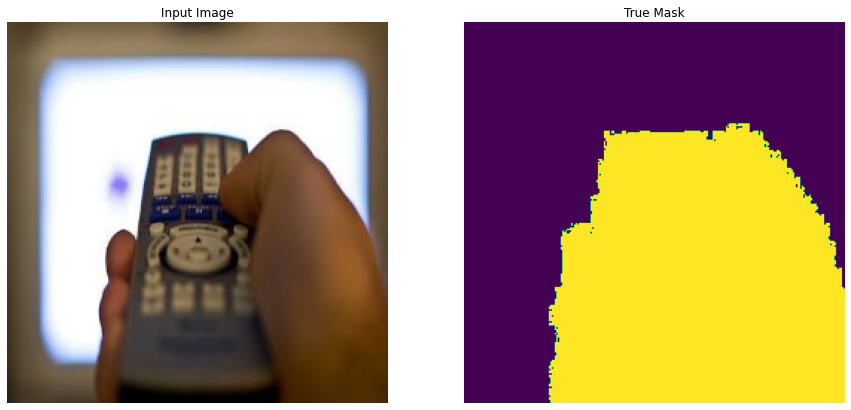

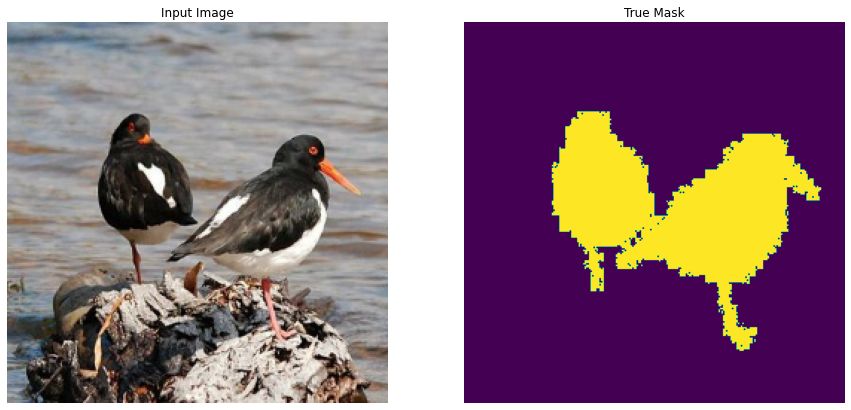

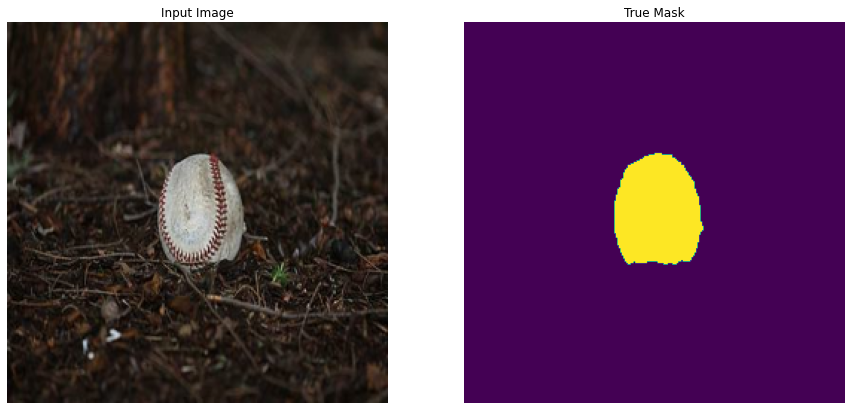

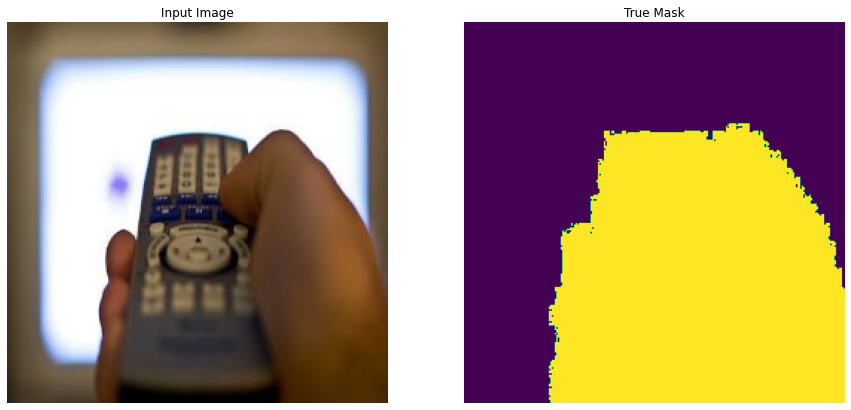

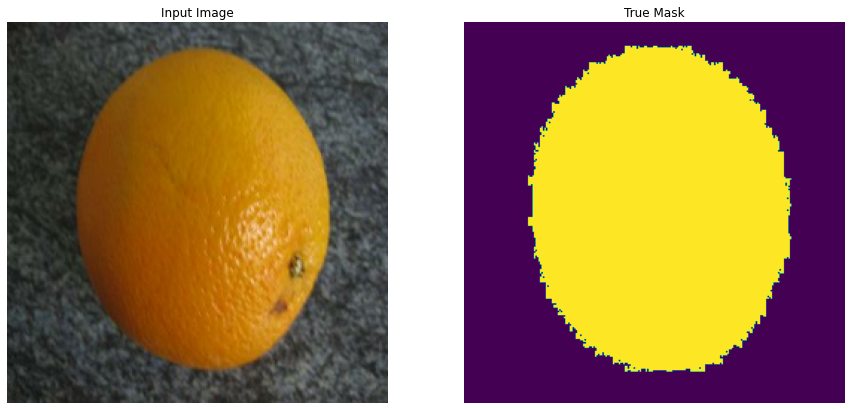

In [22]:
#show image corresponding to the mask
for i in range(5):
   for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])

#Paper:-https://blog.paperspace.com/unet-architecture-image-segmentation/

Explanation of U-net:-https://www.youtube.com/watch?v=yG6GbEtGUrU

###Model--we are going to use U-Net model

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [25]:
#use residual connection
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [27]:
#adding layerouts
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

###Now We are Train the Model

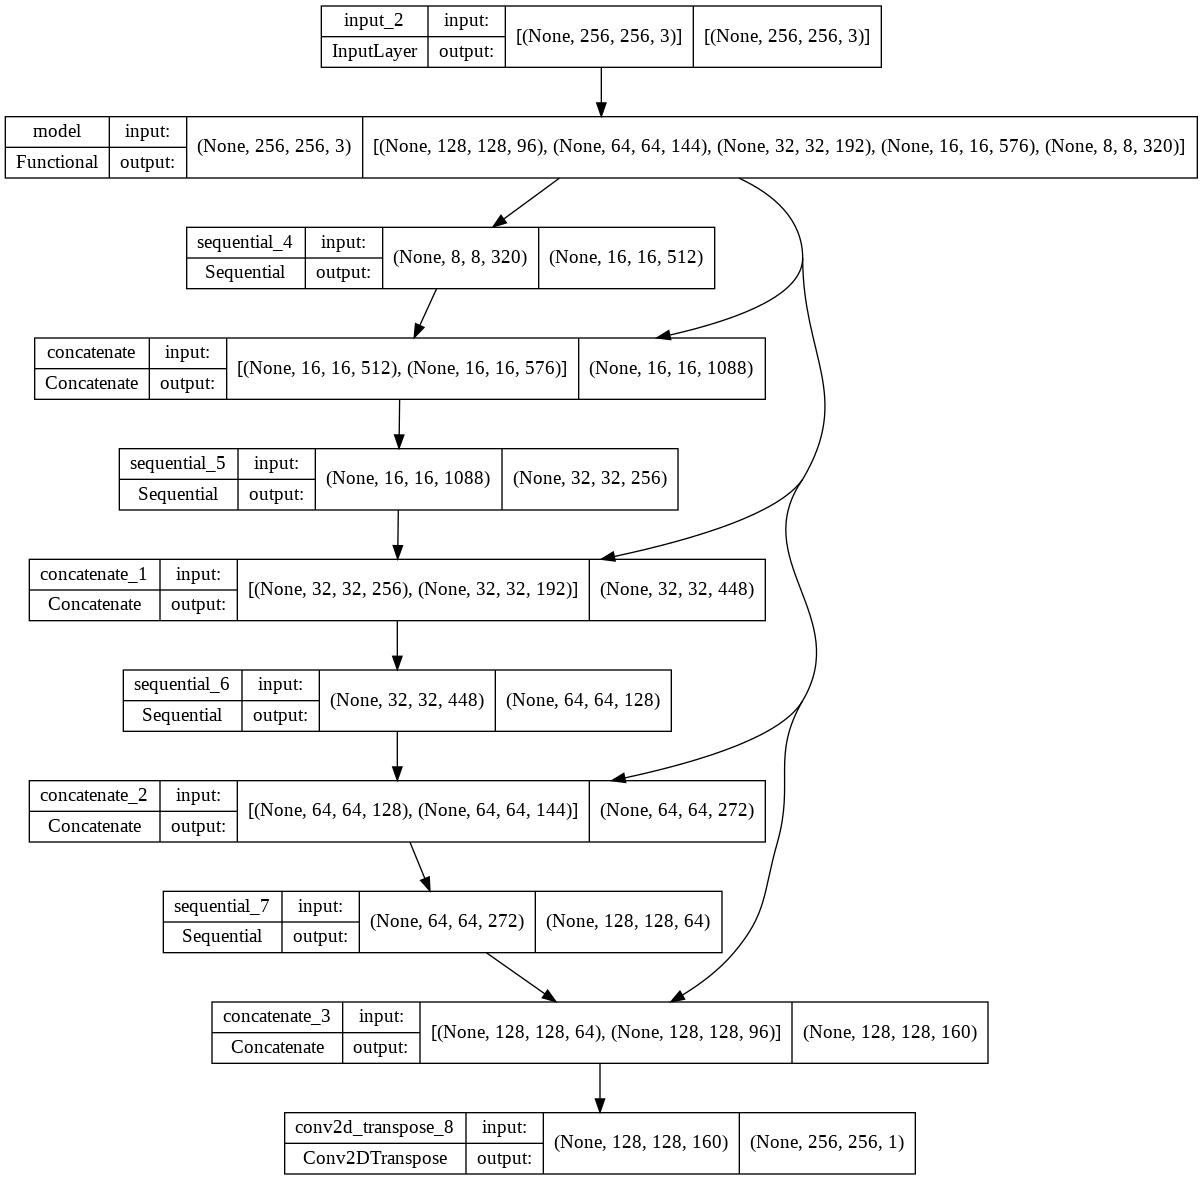

In [29]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer='adam',
              loss = dice_loss,
              metrics=[dice_coef,'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.

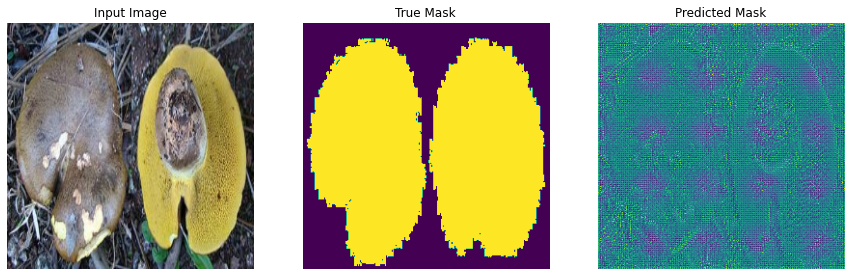

In [30]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])
    
show_predictions(sample_image, sample_mask)

In [31]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 128, 128, 9  1841984     ['input_2[0][0]']                
                                6),                                                               
                                 (None, 64, 64, 144                                               
                                ),                                                                
                                 (None, 32, 32, 192                                         

to inprove the training.we accomplish  the callback function

Epoch 1/10
20/20 [==============================] - 495s 25s/step - loss: 0.2084 - dice_coef: 0.7916 - binary_accuracy: 0.9212 - val_loss: 0.3095 - val_dice_coef: 0.6905 - val_binary_accuracy: 0.7799
Epoch 2/10
20/20 [==============================] - 476s 25s/step - loss: 0.1802 - dice_coef: 0.8198 - binary_accuracy: 0.9230 - val_loss: 0.2449 - val_dice_coef: 0.7551 - val_binary_accuracy: 0.8479


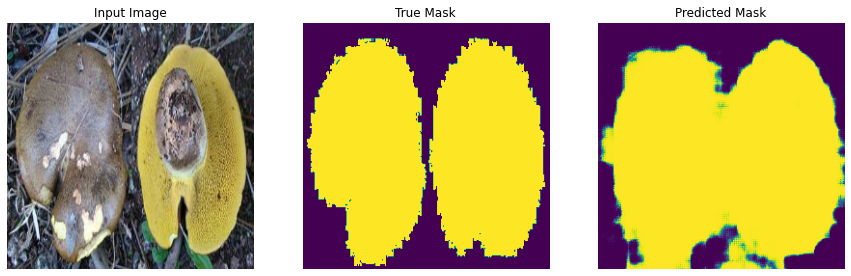

Epoch 3/10
20/20 [==============================] - 485s 25s/step - loss: 0.1665 - dice_coef: 0.8335 - binary_accuracy: 0.9238 - val_loss: 0.1867 - val_dice_coef: 0.8132 - val_binary_accuracy: 0.8970
Epoch 4/10
20/20 [==============================] - 456s 24s/step - loss: 0.1735 - dice_coef: 0.8265 - binary_accuracy: 0.9207 - val_loss: 0.2045 - val_dice_coef: 0.7955 - val_binary_accuracy: 0.8846
Epoch 5/10
20/20 [==============================] - 466s 24s/step - loss: 0.1714 - dice_coef: 0.8286 - binary_accuracy: 0.9210 - val_loss: 0.1774 - val_dice_coef: 0.8226 - val_binary_accuracy: 0.9054


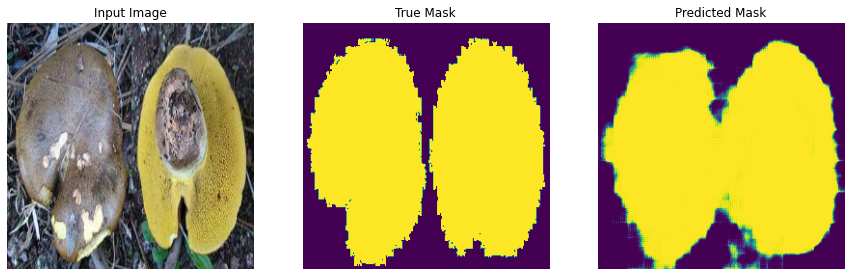

Epoch 6/10
20/20 [==============================] - 464s 24s/step - loss: 0.1562 - dice_coef: 0.8438 - binary_accuracy: 0.9219 - val_loss: 0.1623 - val_dice_coef: 0.8377 - val_binary_accuracy: 0.9151
Epoch 7/10
20/20 [==============================] - 469s 24s/step - loss: 0.1467 - dice_coef: 0.8533 - binary_accuracy: 0.9274 - val_loss: 0.1506 - val_dice_coef: 0.8494 - val_binary_accuracy: 0.9254
Epoch 8/10
20/20 [==============================] - 467s 24s/step - loss: 0.1594 - dice_coef: 0.8406 - binary_accuracy: 0.9231 - val_loss: 0.1645 - val_dice_coef: 0.8355 - val_binary_accuracy: 0.9151


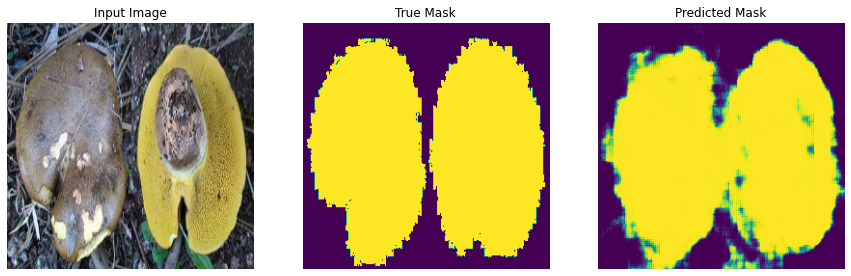

Epoch 9/10
20/20 [==============================] - 471s 25s/step - loss: 0.1675 - dice_coef: 0.8325 - binary_accuracy: 0.9252 - val_loss: 0.1502 - val_dice_coef: 0.8498 - val_binary_accuracy: 0.9249
Epoch 10/10
20/20 [==============================] - ETA: 0s - loss: 0.1505 - dice_coef: 0.8495 - binary_accuracy: 0.9270

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 10
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=20,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback(), early_stop])

The model gives us better accuracy if we train the model on to the stpes per epoch around 450 i try with that but it takes lots of time thats why we not taking high amount of time.and we have to increase the epoch of training also.